In [ ]:
import os
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout, Bidirectional
from sklearn.metrics import roc_curve, auc

In [64]:

class Reader(object):
    def __init__(self, dataset_dir, listfile=None):
        self._dataset_dir = dataset_dir
        self._current_index = 0
        if listfile is None:
            listfile_path = os.path.join(dataset_dir, "listfile.csv")
        else:
            listfile_path = listfile
        with open(listfile_path, "r") as lfile:
            self._data = lfile.readlines()
        self._listfile_header = self._data[0]
        self._data = self._data[1:]

    def get_number_of_examples(self):
        return len(self._data)

    def random_shuffle(self, seed=None):
        if seed is not None:
            random.seed(seed)
        random.shuffle(self._data)

    def read_example(self, index):
        raise NotImplementedError()

    def read_next(self):
        to_read_index = self._current_index
        self._current_index += 1
        if self._current_index == self.get_number_of_examples():
            self._current_index = 0
        return self.read_example(to_read_index)

In [65]:
class InHospitalMortalityReader(Reader):
    def __init__(self, dataset_dir, listfile=None, period_length=48.0):
        """ Reader for in-hospital moratality prediction task.

        :param dataset_dir:   Directory where timeseries files are stored.
        :param listfile:      Path to a listfile. If this parameter is left `None` then
                              `dataset_dir/listfile.csv` will be used.
        :param period_length: Length of the period (in hours) from which the prediction is done.
        """
        Reader.__init__(self, dataset_dir, listfile)
        self._data = [line.split(',') for line in self._data]
        self._data = [(x, int(y)) for (x, y) in self._data]
        self._period_length = period_length

    def _read_timeseries(self, ts_filename):
        ret = []
        with open(os.path.join(self._dataset_dir, ts_filename), "r") as tsfile:
            header = tsfile.readline().strip().split(',')
            assert header[0] == "Hours"
            for line in tsfile:
                mas = line.strip().split(',')
                ret.append(np.array(mas))
        return (np.stack(ret), header)

    def read_example(self, index):
        """ Reads the example with given index.

        :param index: Index of the line of the listfile to read (counting starts from 0).
        :return: Dictionary with the following keys:
            X : np.array
                2D array containing all events. Each row corresponds to a moment.
                First column is the time and other columns correspond to different
                variables.
            t : float
                Length of the data in hours. Note, in general, it is not equal to the
                timestamp of last event.
            y : int (0 or 1)
                In-hospital mortality.
            header : array of strings
                Names of the columns. The ordering of the columns is always the same.
            name: Name of the sample.
        """
        if index < 0 or index >= len(self._data):
            raise ValueError("Index must be from 0 (inclusive) to number of lines (exclusive).")

        name = self._data[index][0]
        t = self._period_length
        y = self._data[index][1]
        (X, header) = self._read_timeseries(name)

        return {"X": X,
                "t": t,
                "y": y,
                "header": header,
                "name": name}





In [66]:
dataset_dir = "C:\\Users\\samit\\OneDrive\\Desktop\\Datasets\\data\\in-hospital-mortality"
root_dir = r'C:\Users\samit\OneDrive\Desktop\Datasets\data\root'

In [70]:
train_reader = InHospitalMortalityReader(dataset_dir=os.path.join(dataset_dir, 'train'),
                                         listfile=os.path.join(dataset_dir, 'train_listfile.csv'),
                                         period_length=48.0)


val_reader = InHospitalMortalityReader(dataset_dir=os.path.join(dataset_dir, 'train'),
                                       listfile=os.path.join(dataset_dir, 'val_listfile.csv'),
                                       period_length=48.0)

test_reader = InHospitalMortalityReader(dataset_dir=os.path.join(dataset_dir, 'test'),
                                       listfile=os.path.join(dataset_dir, 'test_listfile.csv'),
                                       period_length=48.0)

In [71]:
train_reader.read_example(2)

{'X': array([['0.6386111111111111', '', '80.0', ..., '', '', ''],
        ['0.8886111111111111', '', '91.0', ..., '35.833333333333336', '',
         ''],
        ['1.388611111111111', '', '101.0', ..., '35.44444613986545', '',
         '5.0'],
        ...,
        ['46.42194444444444', '', '', ..., '', '', ''],
        ['46.88861111111111', '', '88.0', ..., '', '', ''],
        ['47.88861111111111', '', '94.0', ..., '', '', '']], dtype='<U18'),
 't': 48.0,
 'y': 0,
 'header': ['Hours',
  'Capillary refill rate',
  'Diastolic blood pressure',
  'Fraction inspired oxygen',
  'Glascow coma scale eye opening',
  'Glascow coma scale motor response',
  'Glascow coma scale total',
  'Glascow coma scale verbal response',
  'Glucose',
  'Heart Rate',
  'Height',
  'Mean blood pressure',
  'Oxygen saturation',
  'Respiratory rate',
  'Systolic blood pressure',
  'Temperature',
  'Weight',
  'pH'],
 'name': '13835_episode1_timeseries.csv'}

In [72]:
train_reader.read_example(50)

{'X': array([['0.18694444444444444', '', '45.0', ..., '', '', ''],
        ['1.5369444444444444', '', '', ..., '', '', ''],
        ['2.1869444444444444', '', '52.0', ..., '', '', ''],
        ...,
        ['45.18694444444444', '', '76.0', ..., '37.0', '', ''],
        ['46.18694444444444', '', '76.0', ..., '', '', ''],
        ['47.18694444444444', '', '83.0', ..., '', '', '']], dtype='<U19'),
 't': 48.0,
 'y': 0,
 'header': ['Hours',
  'Capillary refill rate',
  'Diastolic blood pressure',
  'Fraction inspired oxygen',
  'Glascow coma scale eye opening',
  'Glascow coma scale motor response',
  'Glascow coma scale total',
  'Glascow coma scale verbal response',
  'Glucose',
  'Heart Rate',
  'Height',
  'Mean blood pressure',
  'Oxygen saturation',
  'Respiratory rate',
  'Systolic blood pressure',
  'Temperature',
  'Weight',
  'pH'],
 'name': '24266_episode1_timeseries.csv'}

In [73]:
(train_reader.read_example(0)["X"])[1]

array(['0.15', '', '73.0', '', '', '', '', '', '', '128', '', '93',
       '100.0', '25', '133.0', '', '', ''], dtype='<U19')

In [74]:
train_reader.get_number_of_examples()

14681

In [75]:
import os
import pandas as pd

def get_los(data, root_dir, mode='train'):
    # Extract the patient ID and episode number from the 'name' field
    name_parts = data['name'].split('_')
    patient_id = name_parts[0]
    episode_number = name_parts[1]

    # Construct the path to the patient folder
    patient_folder = os.path.join(root_dir, mode, patient_id)

    # Load the episode data
    episode_path = os.path.join(patient_folder, f'{episode_number}.csv')
    episode_data = pd.read_csv(episode_path)

    # Get the ICU stay ID from the episode data
    icu_stay_id = episode_data['Icustay'].values[0]

    # Load the stays data
    stays_path = os.path.join(patient_folder, 'stays.csv')
    stays_data = pd.read_csv(stays_path)

    # Get the length of stay for the specific ICU stay ID
    los = stays_data[stays_data['ICUSTAY_ID'] == int(icu_stay_id)]['LOS'].values[0]

    return los


In [76]:
import numpy as np

def discretize(data, timestep=0.8, impute_strategy='previous', start_time='zero'):
    """
    Discretizes the time series data into fixed timesteps and fills missing values.
    """
    # Sort data by time
    data = sorted(data, key=lambda x: float(x[0]))

    # Create an array for discretized data
    discretized_data = []

    # Fill missing values
    prev_values = None
    for i in range(len(data)):
        if i == 0 and start_time == 'zero':
            row = ['0.0'] + list(data[i][1:])  # Change 0 to '0.0' to match the data type
        else:
            row = list(data[i])

        if impute_strategy == 'previous':
            if prev_values is not None:
                row = [(row[j] if row[j] != '' else prev_values[j]) for j in range(len(row))]
            prev_values = row

        discretized_data.append(row)

    # Transform into fixed timestep format
    time_intervals = np.arange(0, max([float(row[0]) for row in discretized_data]) + timestep, timestep)
    fixed_timestep_data = []
    for t in time_intervals:
        fixed_timestep_data.append([str(t)] + [row[1:] for row in discretized_data if float(row[0]) <= t][-1])

    # Handle missing values (replace empty strings and non-numeric values with '0.0')
    #fixed_timestep_data = [[('0.0' if (cell == '' or not cell.replace('.', '', 1).isdigit()) else cell) for cell in row] for row in fixed_timestep_data]

    # Convert to numerical format and handle missing values
    
    # One-hot encode categorical variables
    # One-hot encode categorical variables
#     for i, channel in enumerate(CHANNELS.keys()):
#         if CHANNELS[channel] == 'categorical':
#             category_mapping = global_category_mapping[channel]
#             one_hot_encoded = np.zeros((len(fixed_timestep_data), len(category_mapping)))
#             for j, category in enumerate(category_mapping.keys()):
#                 one_hot_encoded[np.array(fixed_timestep_data)[:, i+1] == category, category_mapping[category]] = 1
#             fixed_timestep_data = np.column_stack((fixed_timestep_data, one_hot_encoded))
#             fixed_timestep_data = np.delete(fixed_timestep_data, i+1, axis=1)
    for i, channel in enumerate(CHANNELS.keys()):
        if CHANNELS[channel] == 'categorical':
            category_mapping = global_category_mapping[channel]
            fixed_timestep_data_array = np.array(fixed_timestep_data)
            for category, mapped_value in category_mapping.items():
                fixed_timestep_data_array[fixed_timestep_data_array[:, i+1] == category, i+1] = mapped_value
            fixed_timestep_data = fixed_timestep_data_array.tolist()



            
    fixed_timestep_data = [[('0.0' if (cell == '' or not cell.replace('.', '', 1).isdigit()) else cell) for cell in row] for row in fixed_timestep_data]

    df = pd.DataFrame(fixed_timestep_data, columns=['Time'] + ['Var' + str(i) for i in range(1, len(fixed_timestep_data[0]))])
    df = df.replace('', np.nan)
    df = df.fillna(method='ffill')
    df = df.fillna(0)  # Fill any remaining missing values with 0

    # Convert back to numpy array
    numerical_data = df.values.astype(np.float32)
#     numerical_data = np.array(fixed_timestep_data, dtype=np.float32)
#     numerical_data[np.isnan(numerical_data)] = 0


    return numerical_data








In [77]:
from sklearn.preprocessing import StandardScaler

def normalize(data):
    """
    Normalizes the data by scaling the continuous features to have a mean of 0 and a standard deviation of 1.
    """
    channels = CHANNELS
    # Separate time and features
    time = data[:, 0]
    features = data[:, 1:]

    # Identify the indices of the continuous and categorical features
    continuous_indices = [i for i, channel in enumerate(channels.keys()) if channels[channel] == 'numerical']
    categorical_indices = [i for i, channel in enumerate(channels.keys()) if channels[channel] == 'categorical']

    # Separate continuous and categorical features
    continuous_features = features[:, continuous_indices]
    categorical_features = features[:, categorical_indices]

    # Standardize the continuous features
    scaler = StandardScaler()
    standardized_continuous_features = scaler.fit_transform(continuous_features)

    # Create an empty array to hold the standardized features
    standardized_features = np.empty(features.shape, dtype=features.dtype)

    # Put the standardized continuous features back into their original positions
    for i, index in enumerate(continuous_indices):
        standardized_features[:, index] = standardized_continuous_features[:, i]

    # Put the transformed categorical features back into their original positions
    for i, index in enumerate(categorical_indices):
        standardized_features[:, index] = categorical_features[:, i]

    # Concatenate time and standardized features
    normalized_data = np.column_stack((time, standardized_features))

    return normalized_data






In [78]:
def pad_zeros(arr, min_length=None):
    """
    `arr` is an array of `np.array`s

    The function appends zeros to every `np.array` in `arr`
    to equalize their first axis lenghts.
    """
    dtype = arr[0].dtype
    max_len = max([x.shape[0] for x in arr])
    ret = [np.concatenate([x, np.zeros((max_len - x.shape[0],) + x.shape[1:], dtype=dtype)], axis=0)
           for x in arr]
    if (min_length is not None) and ret[0].shape[0] < min_length:
        ret = [np.concatenate([x, np.zeros((min_length - x.shape[0],) + x.shape[1:], dtype=dtype)], axis=0)
               for x in ret]
    return np.array(ret)

In [82]:
CHANNELS = {
    'Capillary refill rate': 'categorical',
    'Diastolic blood pressure': 'numerical',
    'Fraction inspired oxygen': 'numerical',
    'Glascow coma scale eye opening': 'categorical',
    'Glascow coma scale motor response': 'categorical',
    'Glascow coma scale total': 'numerical',
    'Glascow coma scale verbal response': 'categorical',
    'Glucose': 'numerical',
    'Heart Rate': 'numerical',
    'Height': 'numerical',
    'Mean blood pressure': 'numerical',
    'Oxygen saturation': 'numerical',
    'Respiratory rate': 'numerical',
    'Systolic blood pressure': 'numerical',
    'Temperature': 'numerical',
    'Weight': 'numerical',
    'pH':'numerical'
}
# CHANNELS = {
#     'Diastolic blood pressure': 'numerical',
#     'Fraction inspired oxygen': 'numerical',
#     'Glascow coma scale eye opening': 'categorical',
#     'Glascow coma scale motor response': 'categorical',
#     'Glascow coma scale total': 'numerical',
#     'Glascow coma scale verbal response': 'categorical',
#     'Glucose': 'numerical',
#     'Heart Rate': 'numerical',
#     'Mean blood pressure': 'numerical',
#     'Oxygen saturation': 'numerical',
#     'Respiratory rate': 'numerical',
#     'Systolic blood pressure': 'numerical',
#     'Temperature': 'numerical',
#     'Weight': 'numerical'
# }

In [169]:
# from collections import defaultdict

# # Initialize a dictionary to store the unique categories for each categorical variable
# unique_categories = defaultdict(set)

# # Load the time series data for all patients
# for i in range(train_reader.get_number_of_examples()):
#     data = train_reader.read_example(i)
#     for channel, dtype in CHANNELS.items():
#         if dtype == 'categorical':
#             index = data['header'].index(channel)
#             categories = set(data['X'][:, index])
#             unique_categories[channel].update(categories)

# # Create a global mapping of categories to indices for each categorical variable
# global_category_mapping = {}
# for channel, categories in unique_categories.items():
#     global_category_mapping[channel] = {category: i for i, category in enumerate(categories)}

In [79]:
global_category_mapping = {'Capillary refill rate': {'': 0,
  '0.0': 1,
  '1': 2 },
  'Glascow coma scale eye opening': {'': 0,
  'To Pain': 1,
  'None': 2,
  'Spontaneously': 3,
  'To Speech': 4,
  '4 Spontaneously': 5,
  '1 No Response': 6,
  '2 To pain': 7,
  '3 To speech': 8},
 'Glascow coma scale motor response': {'': 0,
  'Localizes Pain': 1,
  '3 Abnorm flexion': 2,
  'Abnormal extension': 3,
  '5 Localizes Pain': 4,
  '6 Obeys Commands': 5,
  'Flex-withdraws': 6,
  '2 Abnorm extensn': 7,
  'Obeys Commands': 8,
  'Abnormal Flexion': 9,
  'No response': 10,
  '4 Flex-withdraws': 11,
  '1 No Response': 12},
 'Glascow coma scale verbal response': {'': 0,
  'Inappropriate Words': 1,
  'Incomprehensible sounds': 2,
  'Oriented': 3,
  '2 Incomp sounds': 4,
  '4 Confused': 5,
  'No Response-ETT': 6,
  '3 Inapprop words': 7,
  'Confused': 8,
  'No Response': 9,
  '1.0 ET/Trach': 10,
  '5 Oriented': 11,
  '1 No Response': 12}}

In [80]:
# Define the mappings for the categorical columns
admission_mapping = {'UNKNOWN': 0, 'EMERGENCY': 1, 'ELECTIVE': 2, 'URGENT': 3}
dbsource_mapping = {'carevue': 1, 'metavision': 2, 'both': 3}
icu_unit_mapping = {'MICU': 1, 'CCU': 2, 'TSICU': 3, 'SICU': 4, 'CSRU': 5}

def get_static_features(reader, index, root):
    # Read the example from the reader
    example = reader.read_example(index)
    
    # Extract the patient ID and episode number from the file name
    file_name = example['name']
    patient_id, episode_num = file_name.split('_')[0], file_name.split('_')[1].replace('episode', '')
    
    # Define the root directory and train folder
    if root == 'train':
        train_dir = os.path.join(root_dir, 'train')
    elif root == 'test':
        train_dir = os.path.join(root_dir, 'test')
    
    # Load the combined data
    combined_data = pd.read_csv('combined_data')
    
    # Access the patient folder
    patient_path = os.path.join(train_dir, patient_id)
    
    # Load the stays data
    stays_data = pd.read_csv(os.path.join(patient_path, 'stays.csv'))
    
    # Access the episode folder
    #episode_path = os.path.join(patient_path, f'episode{episode_num}')
    
    # Load the episode data
    episode_data = pd.read_csv(os.path.join(patient_path, f'episode{episode_num}.csv'))
    
    # Extract the relevant features
    age = episode_data['Age'].values[0]
    height = episode_data['Height'].values[0]
    weight = episode_data['Weight'].values[0]
    ethnicity = episode_data['Ethnicity'].values[0]
    gender = episode_data['Gender'].values[0]
    dbsource = stays_data['DBSOURCE'].values[0]
    last_careunit = stays_data['LAST_CAREUNIT'].values[0]
    
    # Get the admission type from the combined data
    # Get the admission type from the combined data
    icustay_id = stays_data['ICUSTAY_ID'].values[0]
    matching_rows = combined_data[combined_data['ICUSTAY_ID'] == icustay_id]

    if not matching_rows.empty:
        admission_type = matching_rows['ADMISSION_TYPE'].values[0]
    else:
        # Handle the case where there are no matching rows
        print(f"No matching rows found for ICUSTAY_ID {icustay_id}")
        admission_type = "UNKNOWN"

    
    # Create the static data vector
    static_data_vector = [age, height, weight, gender,ethnicity, dbsource, last_careunit, admission_type]
#     static_data_df = pd.DataFrame(static_data_vectors, columns=['Age', 'Height', 'Weight', 'Gender', 'Ethnicity', 'DBSource', 'LastCareUnit', 'AdmissionType'])
#     # Apply the mappings to the static data DataFrame
#     static_data_df['AdmissionType'] = static_data_df['AdmissionType'].map(admission_mapping)
#     static_data_df['DBSource'] = static_data_df['DBSource'].map(dbsource_mapping)
#     static_data_df['LastCareUnit'] = static_data_df['LastCareUnit'].map(icu_unit_mapping)
#     static_data_vector = static_data_df.loc[0, :].values.tolist()

    return static_data_vector

In [99]:
# Process training data
from keras.utils import to_categorical
train_data_timeseries = []
train_data_static = []
train_labels = []
#drop_features = ['Height', 'Capillary refill rate']

for i in range(train_reader.get_number_of_examples()):
    example = train_reader.read_example(i)
    #     drop_indices = [example['header'].index(feature) for feature in drop_features]
    #     data = np.array(example['X'], dtype='<U20')
    #     data = np.delete(data, drop_indices, axis=1)
    #     example['X'] = data
    #     example['header'] = [header for j, header in enumerate(example['header']) if j not in drop_indices]
    discretized_data = discretize(example['X'])
    normalized_data = normalize(discretized_data)

    # Get the static data vector
    static_data_vector = get_static_features(train_reader, i,'train')
    for j in range(len(static_data_vector)):
        if isinstance(static_data_vector[j], (int, float)):
            static_data_vector[j] = float(static_data_vector[j])
        # Convert the static data vector into a numpy array and repeat it to match the shape of the time series data
    static_data_array = np.array(static_data_vector,dtype=object)
    #static_data_array = np.repeat(np.array(static_data_vector)[np.newaxis, :], normalized_data.shape[0], axis=0)

    # Concatenate the static data array with the time series data
    #concatenated_data = np.concatenate((normalized_data, static_data_array), axis=1)

    train_data_timeseries.append(normalized_data)
    train_data_static.append(static_data_array)
    label = get_los(example,root_dir,'train')
    train_labels.append(label)
padded_train_data = pad_zeros(train_data_timeseries)
static_data_df = pd.DataFrame(train_data_static, columns=['Age', 'Height', 'Weight', 'Gender', 'Ethnicity', 'DBSource', 'LastCareUnit', 'AdmissionType'])
static_data_df['AdmissionType'] = static_data_df['AdmissionType'].map(admission_mapping)
static_data_df['DBSource'] = static_data_df['DBSource'].map(dbsource_mapping)
static_data_df['LastCareUnit'] = static_data_df['LastCareUnit'].map(icu_unit_mapping)
numerical_features = ['Age', 'Height', 'Weight']
# Standardize the numerical features
scaler = StandardScaler()
scaler.fit(static_data_df[numerical_features])
static_data_df[numerical_features] = scaler.transform(static_data_df[numerical_features])
train_data_static = static_data_df.to_numpy()

#padded_train_data = np.concatenate(padded_train_data, axis=0)
#train_labels = to_categorical(train_labels)

# Process validation data
val_data_timeseries = []
val_data_static = []
val_labels = []
for i in range(val_reader.get_number_of_examples()):
    example = val_reader.read_example(i)
#     drop_indices = [example['header'].index(feature) for feature in drop_features]
#     data = np.array(example['X'], dtype='<U20')
#     data = np.delete(data, drop_indices, axis=1)
#     example['X'] = data
#     example['header'] = [header for j, header in enumerate(example['header']) if j not in drop_indices]
    discretized_data = discretize(example['X'])
    normalized_data = normalize(discretized_data)

    # Get the static data vector
    static_data_vector_val = get_static_features(val_reader, i,'train')
    for j in range(len(static_data_vector_val)):
        if isinstance(static_data_vector_val[j], (int, float)):
            static_data_vector_val[j] = float(static_data_vector_val[j])

    # Convert the static data vector into a numpy array and repeat it to match the shape of the time series data
    static_data_array_val = np.array(static_data_vector_val, dtype=object)

    val_data_timeseries.append(normalized_data)
    val_data_static.append(static_data_array_val)
    label = get_los(example,root_dir,'train')
    val_labels.append(label)
padded_val_data = pad_zeros(val_data_timeseries)
static_data_val_df = pd.DataFrame(val_data_static, columns=['Age', 'Height', 'Weight', 'Gender', 'Ethnicity', 'DBSource', 'LastCareUnit', 'AdmissionType'])
static_data_val_df['AdmissionType'] = static_data_val_df['AdmissionType'].map(admission_mapping)
static_data_val_df['DBSource'] = static_data_val_df['DBSource'].map(dbsource_mapping)
static_data_val_df['LastCareUnit'] = static_data_val_df['LastCareUnit'].map(icu_unit_mapping)
static_data_val_df[numerical_features] = scaler.transform(static_data_val_df[numerical_features])
val_data_static = static_data_val_df.to_numpy()
#padded_val_data = np.concatenate(padded_val_data, axis=0)
#val_labels = to_categorical(val_labels)


No matching rows found for ICUSTAY_ID 283217


In [100]:
test_data_timeseries = []
test_data_static = []
test_labels = []
for i in range(test_reader.get_number_of_examples()):
    example = test_reader.read_example(i)
#     drop_indices = [example['header'].index(feature) for feature in drop_features]
#     data = np.array(example['X'], dtype='<U20')
#     data = np.delete(data, drop_indices, axis=1)
#     example['X'] = data
#     example['header'] = [header for j, header in enumerate(example['header']) if j not in drop_indices]
    discretized_data = discretize(example['X'])
    normalized_data = normalize(discretized_data)

    # Get the static data vector
    static_data_vector_test = get_static_features(test_reader, i,'test')
    for j in range(len(static_data_vector_test)):
        if isinstance(static_data_vector_test[j], (int, float)):
            static_data_vector_test[j] = float(static_data_vector_test[j])

    # Convert the static data vector into a numpy array and repeat it to match the shape of the time series data
    static_data_array_test = np.array(static_data_vector_test, dtype=object)

    test_data_timeseries.append(normalized_data)
    test_data_static.append(static_data_array_test)
    label = get_los(example,root_dir,'test')
    test_labels.append(label)
padded_test_data = pad_zeros(test_data_timeseries)
static_data_test_df = pd.DataFrame(test_data_static, columns=['Age', 'Height', 'Weight', 'Gender', 'Ethnicity', 'DBSource', 'LastCareUnit', 'AdmissionType'])
static_data_test_df['AdmissionType'] = static_data_test_df['AdmissionType'].map(admission_mapping)
static_data_test_df['DBSource'] = static_data_test_df['DBSource'].map(dbsource_mapping)
static_data_test_df['LastCareUnit'] = static_data_test_df['LastCareUnit'].map(icu_unit_mapping)
static_data_test_df[numerical_features] = scaler.transform(static_data_test_df[numerical_features])
test_data_static = static_data_test_df.to_numpy()

In [101]:
test_data_static

array([[-0.72439295,         nan, -0.95239509, ...,  1.        ,
         1.        ,  1.        ],
       [ 4.07634932,         nan, -0.67542541, ...,  1.        ,
         4.        ,  1.        ],
       [ 0.02334562,         nan, -0.42538337, ...,  1.        ,
         2.        ,  3.        ],
       ...,
       [-0.60606243,  0.9906259 ,  1.46724253, ...,  2.        ,
         4.        ,  1.        ],
       [-0.03847865, -0.23973868, -0.80768941, ...,  2.        ,
         2.        ,  1.        ],
       [ 0.19942638, -0.92327457, -0.8254507 , ...,  2.        ,
         1.        ,  1.        ]])

In [104]:
padded_val_data.shape

(3222, 61, 18)

In [105]:
import numpy as np

# Calculate the number of nan values in each column of padded_train_data
nan_counts_padded = np.isnan(padded_train_data).sum(axis=0)

# Calculate the total number of values in each column of padded_train_data
total_counts_padded = padded_train_data.shape[0]

# Calculate the percentage of nan values in each column of padded_train_data
nan_percentage_padded = (nan_counts_padded / total_counts_padded) * 100

# Calculate the number of nan values in each column of train_static_data
nan_counts_static = np.isnan(train_data_static).sum(axis=0)

# Calculate the total number of values in each column of train_static_data
total_counts_static = train_data_static.shape[0]

# Calculate the percentage of nan values in each column of train_static_data
nan_percentage_static = (nan_counts_static / total_counts_static) * 100

print("Percentage of nan values in each column of padded_train_data:", nan_percentage_padded)
print("Percentage of nan values in each column of train_static_data:", nan_percentage_static)



Percentage of nan values in each column of padded_train_data: [[0.         0.         0.         ... 0.         0.         5.46284313]
 [0.         0.         0.         ... 0.         0.         2.05708058]
 [0.         0.         0.         ... 0.         0.         0.17709965]
 ...
 [0.         0.         0.         ... 0.         0.         0.17028813]
 [0.         0.         0.         ... 0.         0.         0.0817383 ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Percentage of nan values in each column of train_static_data: [ 0.         74.44996935 13.94319188  0.          0.          0.
  0.          0.        ]


In [106]:
for i in range(padded_train_data.shape[0]):
    for j in range(padded_train_data.shape[1]):
        dataset = padded_train_data[i, j, :]
        nan_indices = np.isnan(dataset)
        mean_value = np.nanmean(dataset)
        dataset[nan_indices] = mean_value
        padded_train_data[i, j, :] = dataset

In [107]:
# Do the same for the validation data
for i in range(padded_val_data.shape[0]):
    for j in range(padded_val_data.shape[1]):
        dataset = padded_val_data[i, j, :]
        nan_indices = np.isnan(dataset)
        mean_value = np.nanmean(dataset)
        dataset[nan_indices] = mean_value
        padded_val_data[i, j, :] = dataset

In [108]:
for i in range(padded_test_data.shape[0]):
    for j in range(padded_test_data.shape[1]):
        dataset = padded_test_data[i, j, :]
        nan_indices = np.isnan(dataset)
        mean_value = np.nanmean(dataset)
        dataset[nan_indices] = mean_value
        padded_test_data[i, j, :] = dataset

In [109]:
import numpy as np

# Assuming val_data_static is a numpy array
column_index_to_drop = 1  # Index of the column with 74.45% nan values
train_data_static_new = np.delete(train_data_static, column_index_to_drop, axis=1)
val_data_static_new = np.delete(val_data_static, column_index_to_drop, axis=1)

In [110]:
column_index_to_drop = 1
test_data_static = np.delete(test_data_static,column_index_to_drop, axis=1 ) 

In [111]:
import numpy as np

# Assuming train_static_data and val_static_data are your static data arrays
# Assuming the weight column is the second column (index 1)

# Calculate the mean of the non-missing values in the weight column of the training data
mean_weight_train = np.nanmean(train_data_static_new[:, 1])

# Impute the missing values in the weight column of the training data with the mean
train_data_static_new[:, 1] = np.where(np.isnan(train_data_static_new[:, 1]), mean_weight_train, train_data_static_new[:, 1])

# Impute the missing values in the weight column of the validation data with the mean from the training data
val_data_static_new[:, 1] = np.where(np.isnan(val_data_static_new[:, 1]), mean_weight_train, val_data_static_new[:, 1])


In [112]:
test_data_static[:, 1] = np.where(np.isnan(test_data_static[:, 1]), mean_weight_train, test_data_static[:, 1])

In [113]:
train_data_static = train_data_static_new
val_data_static = val_data_static_new 

In [280]:
# Count the number of LOS less than 2
count_los_less_than_2 = np.sum(train_labels < 2)

print("Number of LOS less than 2:", count_los_less_than_2)

Number of LOS less than 2: 0


In [288]:
import pandas as pd

# Define the bin edges
bins = [2, 3, 4, 5, 6, 7, 8, 14, float('inf')]

# Define the bin labels
labels = ['2-3 days', '3-4 days', '4-5 days', '5-6 days', '6-7 days', '7-8 days', '8-14 days', '14+ days']

# Map the train_labels to the bins
train_labels_binned = pd.cut(train_labels, bins=bins, labels=labels, right=False)
val_labels_binned = pd.cut(val_labels, bins=bins, labels=labels, right=False)
test_labels_binned = pd.cut(test_labels, bins=bins, labels=labels, right=False)
# One-hot encode the binned labels
train_labels_onehot = pd.get_dummies(train_labels_binned)
val_labels_onehot = pd.get_dummies(val_labels_binned)
test_labels_onehot = pd.get_dummies(test_labels_binned)
print("One-hot encoded train labels:")
train_labels_onehot.head()


One-hot encoded train labels:


,2-3 days,3-4 days,4-5 days,5-6 days,6-7 days,7-8 days,8-14 days,14+ days
0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1


In [313]:
train_labels_arr = train_labels_onehot.values
val_labels_arr = val_labels_onehot.values
test_labels_arr = test_labels_onehot.values

In [290]:
train_labels_arr.shape

(14681, 8)

In [312]:
train_labels_arr

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [292]:
test_labels_onehot.shape

(3236, 8)

In [294]:
padded_test_data.shape

(3236, 61, 18)

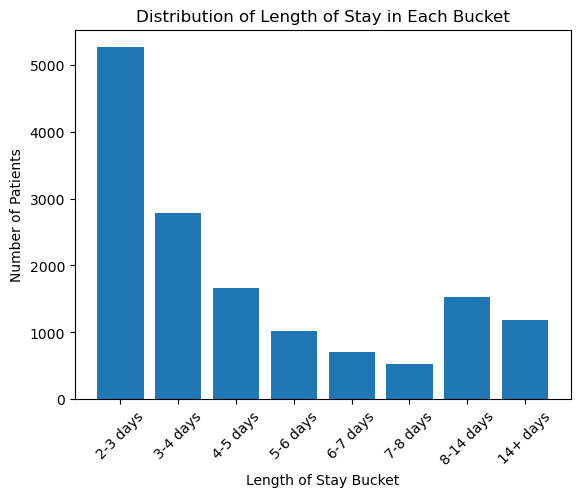

In [297]:
import matplotlib.pyplot as plt

# Get the value counts of the binned data
value_counts = train_labels_binned.value_counts()

# Create a bar plot of the distribution of the binned data
plt.bar(value_counts.index, value_counts.values)

# Add a title and labels to the axes
plt.title('Distribution of Length of Stay in Each Bucket')
plt.xlabel('Length of Stay Bucket')
plt.ylabel('Number of Patients')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [388]:
value_counts

2-3 days     5264
3-4 days     2780
4-5 days     1669
5-6 days     1024
6-7 days      709
7-8 days      528
8-14 days    1527
14+ days     1180
dtype: int64

In [298]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout

# Define the input shape for the time series data
time_series_input = Input(shape=(None, padded_train_data.shape[2]))

# Define the input shape for the static features
static_input = Input(shape=(train_data_static.shape[1],))

# Define the LSTM layers for the time series data
lstm_layer = LSTM(64, return_sequences=True)(time_series_input)
lstm_layer = LSTM(32)(lstm_layer)

# Concatenate the LSTM output with the static features
concat_layer = Concatenate()([lstm_layer, static_input])

# Define the dense layers
dense_layer = Dense(64, activation='relu')(concat_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add a Dropout layer with a rate of 0.3
dense_layer = Dense(32, activation='relu')(dense_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add another Dropout layer with a rate of 0.3

# Define the output layer for multi-class classification (use softmax activation)
num_classes = train_labels_onehot.shape[1]  # Get the number of classes from the one-hot encoded labels
output_layer = Dense(num_classes, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[time_series_input, static_input], outputs=output_layer)

# Compile the model with categorical_crossentropy loss for multi-class classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, None, 18)]   0           []                               
                                                                                                  
 lstm_32 (LSTM)                 (None, None, 64)     21248       ['input_34[0][0]']               
                                                                                                  
 lstm_33 (LSTM)                 (None, 32)           12416       ['lstm_32[0][0]']                
                                                                                                  
 input_35 (InputLayer)          [(None, 7)]          0           []                               
                                                                                           

In [301]:
history = model.fit(
    [padded_train_data, train_data_static], train_labels_onehot,
    validation_data=([padded_val_data, val_data_static], val_labels_onehot),
    epochs=20,
    batch_size=32
)

Epoch 1/20
459/459 [==============================] - 35s 66ms/step - loss: 1.8708 - accuracy: 0.3387 - val_loss: 1.8059 - val_accuracy: 0.3476
Epoch 2/20
459/459 [==============================] - 25s 54ms/step - loss: 1.7899 - accuracy: 0.3607 - val_loss: 1.7205 - val_accuracy: 0.3669
Epoch 3/20
459/459 [==============================] - 25s 55ms/step - loss: 1.7367 - accuracy: 0.3792 - val_loss: 1.7024 - val_accuracy: 0.3849
Epoch 4/20
459/459 [==============================] - 27s 59ms/step - loss: 1.7222 - accuracy: 0.3835 - val_loss: 1.6785 - val_accuracy: 0.3942
Epoch 5/20
459/459 [==============================] - 26s 56ms/step - loss: 1.7019 - accuracy: 0.3899 - val_loss: 1.6690 - val_accuracy: 0.3945
Epoch 6/20
459/459 [==============================] - 26s 57ms/step - loss: 1.7008 - accuracy: 0.3902 - val_loss: 1.6647 - val_accuracy: 0.3932
Epoch 7/20
459/459 [==============================] - 26s 57ms/step - loss: 1.6932 - accuracy: 0.3965 - val_loss: 1.6586 - val_accuracy:

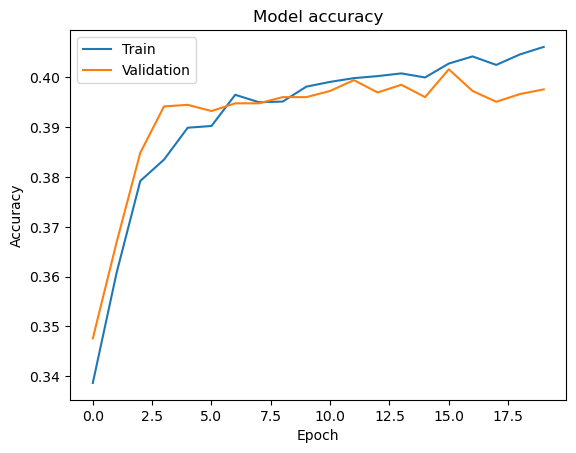

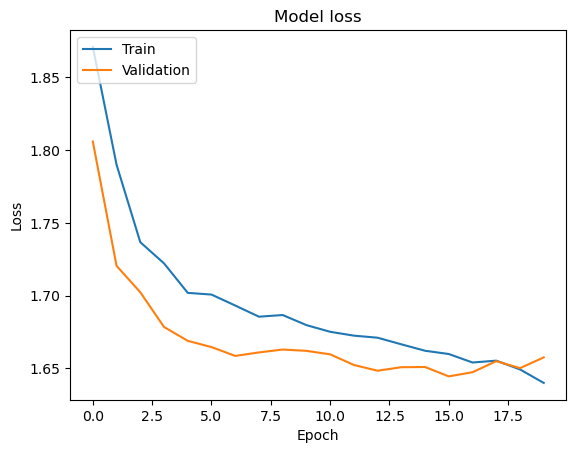

In [303]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [305]:
y_pred = model.predict([padded_test_data, test_data_static])

102/102 [==============================] - 2s 22ms/step


In [307]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [308]:
y_pred_classes

array([0, 0, 0, ..., 6, 0, 6], dtype=int64)

In [311]:
test_labels_onehot

,2-3 days,3-4 days,4-5 days,5-6 days,6-7 days,7-8 days,8-14 days,14+ days
0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
3231,0,1,0,0,0,0,0,0
3232,0,0,0,1,0,0,0,0
3233,0,0,0,0,0,0,0,1
3234,1,0,0,0,0,0,0,0


In [323]:
y_pred_classes

array([0, 0, 0, ..., 6, 0, 6], dtype=int64)

In [322]:
y_true_classes

array([6, 0, 0, ..., 7, 0, 6], dtype=int64)

In [325]:
# Predict the classes on the validation set
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

y_pred = model.predict([padded_test_data, test_data_static])
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded validation labels to class labels
y_true_classes = np.argmax(test_labels_arr, axis=1)

# Print the classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Print the accuracy
print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))

# Print the macro F1 score
print("Macro F1 Score:", f1_score(y_true_classes, y_pred_classes, average='macro'))

# Print the macro precision
print("Macro Precision:", precision_score(y_true_classes, y_pred_classes, average='macro'))

# Print the macro recall
print("Macro Recall:", recall_score(y_true_classes, y_pred_classes, average='macro'))

# Print the macro and micro AUC-ROC scores
print("Macro AUC-ROC Score:", roc_auc_score(test_labels_arr, y_pred, average='macro', multi_class='ovr'))
print("Micro AUC-ROC Score:", roc_auc_score(test_labels_arr, y_pred, average='micro', multi_class='ovr'))

102/102 [==============================] - 2s 23ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.93      0.63      1194
           1       0.18      0.00      0.01       577
           2       0.00      0.00      0.00       371
           3       0.00      0.00      0.00       228
           4       0.00      0.00      0.00       160
           5       0.00      0.00      0.00       103
           6       0.24      0.63      0.34       343
           7       0.25      0.00      0.01       260

    accuracy                           0.41      3236
   macro avg       0.14      0.20      0.12      3236
weighted avg       0.25      0.41      0.27      3236

Accuracy: 0.4100741656365884
Macro F1 Score: 0.12401534305714312
Macro Precision: 0.14365461943139657
Macro Recall: 0.19588763724608366
Macro AUC-ROC Score: 0.6442239453233174
Micro AUC-ROC Score: 0.7800001001338683


C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metr

In [330]:
from sklearn.utils.class_weight import compute_class_weight

# Convert the one-hot encoded labels back to class labels
y_true_classes = np.argmax(train_labels_arr, axis=1)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_true_classes), y=y_true_classes)
class_weights_dict = dict(enumerate(class_weights))

In [332]:
class_weights_dict

{0: 0.34861797112462006,
 1: 0.6601169064748201,
 2: 1.099535650089874,
 3: 1.7921142578125,
 4: 2.5883286318758816,
 5: 3.4756155303030303,
 6: 1.201784544859201,
 7: 1.5551906779661018}

In [340]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout

# Define the input shape for the time series data
time_series_input = Input(shape=(None, padded_train_data.shape[2]))

# Define the input shape for the static features
static_input = Input(shape=(train_data_static.shape[1],))

# Define the LSTM layers for the time series data
lstm_layer = LSTM(64, return_sequences=True)(time_series_input)
lstm_layer = LSTM(32)(lstm_layer)

# Concatenate the LSTM output with the static features
concat_layer = Concatenate()([lstm_layer, static_input])

# Define the dense layers
dense_layer = Dense(64, activation='relu')(concat_layer)
dense_layer = Dropout(0.2)(dense_layer)  # Add a Dropout layer with a rate of 0.3
dense_layer = Dense(32, activation='relu')(dense_layer)
dense_layer = Dropout(0.2)(dense_layer)  # Add another Dropout layer with a rate of 0.3

# Define the output layer for multi-class classification (use softmax activation)
num_classes = train_labels_onehot.shape[1]  # Get the number of classes from the one-hot encoded labels
output_layer = Dense(num_classes, activation='softmax')(dense_layer)

# Create the model
model1 = Model(inputs=[time_series_input, static_input], outputs=output_layer)

# Compile the model with categorical_crossentropy loss for multi-class classification
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model1.summary()




Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, None, 18)]   0           []                               
                                                                                                  
 lstm_42 (LSTM)                 (None, None, 64)     21248       ['input_42[0][0]']               
                                                                                                  
 lstm_43 (LSTM)                 (None, 32)           12416       ['lstm_42[0][0]']                
                                                                                                  
 input_43 (InputLayer)          [(None, 7)]          0           []                               
                                                                                           

In [341]:
history1 = model1.fit(
    [padded_train_data, train_data_static], train_labels_onehot,
    validation_data=([padded_val_data, val_data_static], val_labels_onehot),
    epochs=20,
    batch_size=32
)

Epoch 1/20
459/459 [==============================] - 33s 62ms/step - loss: 1.8621 - accuracy: 0.3416 - val_loss: 1.8086 - val_accuracy: 0.3476
Epoch 2/20
459/459 [==============================] - 28s 60ms/step - loss: 1.7870 - accuracy: 0.3607 - val_loss: 1.7120 - val_accuracy: 0.3718
Epoch 3/20
459/459 [==============================] - 26s 57ms/step - loss: 1.7328 - accuracy: 0.3778 - val_loss: 1.6899 - val_accuracy: 0.3852
Epoch 4/20
459/459 [==============================] - 27s 60ms/step - loss: 1.7134 - accuracy: 0.3857 - val_loss: 1.6815 - val_accuracy: 0.3883
Epoch 5/20
459/459 [==============================] - 27s 59ms/step - loss: 1.7020 - accuracy: 0.3869 - val_loss: 1.6735 - val_accuracy: 0.3873
Epoch 6/20
459/459 [==============================] - 28s 60ms/step - loss: 1.6920 - accuracy: 0.3946 - val_loss: 1.6637 - val_accuracy: 0.3929
Epoch 7/20
459/459 [==============================] - 28s 61ms/step - loss: 1.6883 - accuracy: 0.3932 - val_loss: 1.6810 - val_accuracy:

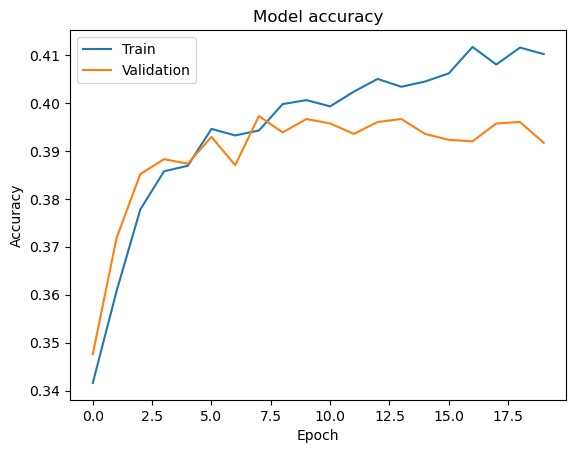

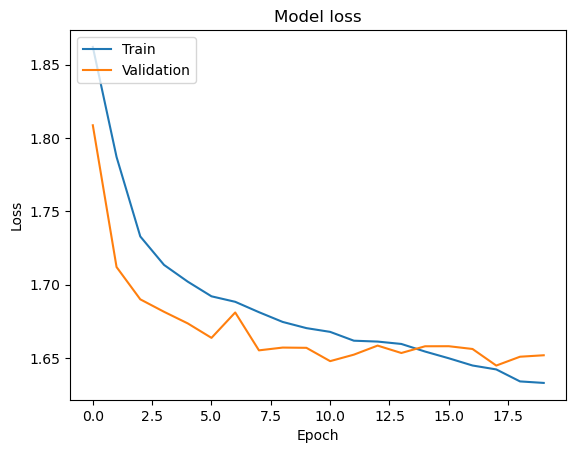

In [342]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [343]:
y_pred = model1.predict([padded_test_data, test_data_static])
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded validation labels to class labels
y_true_classes = np.argmax(test_labels_arr, axis=1)

# Print the classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Print the accuracy
print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))

# Print the macro F1 score
print("Macro F1 Score:", f1_score(y_true_classes, y_pred_classes, average='macro'))

# Print the macro precision
print("Macro Precision:", precision_score(y_true_classes, y_pred_classes, average='macro'))

# Print the macro recall
print("Macro Recall:", recall_score(y_true_classes, y_pred_classes, average='macro'))

# Print the macro and micro AUC-ROC scores
print("Macro AUC-ROC Score:", roc_auc_score(test_labels_arr, y_pred, average='macro', multi_class='ovr'))
print("Micro AUC-ROC Score:", roc_auc_score(test_labels_arr, y_pred, average='micro', multi_class='ovr'))

102/102 [==============================] - 4s 22ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.94      0.62      1194
           1       0.18      0.02      0.03       577
           2       0.00      0.00      0.00       371
           3       1.00      0.00      0.01       228
           4       0.00      0.00      0.00       160
           5       0.00      0.00      0.00       103
           6       0.25      0.46      0.32       343
           7       0.25      0.12      0.16       260

    accuracy                           0.41      3236
   macro avg       0.27      0.19      0.14      3236
weighted avg       0.32      0.41      0.28      3236

Accuracy: 0.4088380716934487
Macro F1 Score: 0.14320662210299134
Macro Precision: 0.2673035397327766
Macro Recall: 0.19302977763546808
Macro AUC-ROC Score: 0.6494474704406468
Micro AUC-ROC Score: 0.782905169188585


C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metr

In [349]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout, Bidirectional

# Define the input shape for the time series data
time_series_input = Input(shape=(None, padded_train_data.shape[2]))

# Define the input shape for the static features
static_input = Input(shape=(train_data_static.shape[1],))

# Define the Bidirectional LSTM layers for the time series data
bi_lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(time_series_input)
bi_lstm_layer = Bidirectional(LSTM(32))(bi_lstm_layer)

# Concatenate the LSTM output with the static features
concat_layer = Concatenate()([bi_lstm_layer, static_input])

# Define the dense layers
dense_layer = Dense(64, activation='relu')(concat_layer)
dense_layer = Dropout(0.2)(dense_layer)  # Add a Dropout layer with a rate of 0.5
dense_layer = Dense(32, activation='relu')(dense_layer)
dense_layer = Dropout(0.2)(dense_layer)  # Add another Dropout layer with a rate of 0.5

# Define the output layer for multi-class classification (use softmax activation)
num_classes = train_labels_onehot.shape[1]  # Get the number of classes from the one-hot encoded labels
output_layer = Dense(num_classes, activation='softmax')(dense_layer)

# Create the model
model2 = Model(inputs=[time_series_input, static_input], outputs=output_layer)

# Compile the model with categorical_crossentropy loss for multi-class classification
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model2.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_48 (InputLayer)          [(None, None, 18)]   0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, None, 128)   42496       ['input_48[0][0]']               
 )                                                                                                
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 64)          41216       ['bidirectional_2[0][0]']        
 )                                                                                                
                                                                                           

In [350]:
history2 = model2.fit(
    [padded_train_data, train_data_static], train_labels_onehot,
    validation_data=([padded_val_data, val_data_static], val_labels_onehot),
    epochs=15,
    batch_size=32
)

Epoch 1/15
459/459 [==============================] - 38s 62ms/step - loss: 1.8454 - accuracy: 0.3468 - val_loss: 1.7841 - val_accuracy: 0.3476
Epoch 2/15
459/459 [==============================] - 23s 50ms/step - loss: 1.7695 - accuracy: 0.3646 - val_loss: 1.7099 - val_accuracy: 0.3718
Epoch 3/15
459/459 [==============================] - 22s 49ms/step - loss: 1.7279 - accuracy: 0.3787 - val_loss: 1.6930 - val_accuracy: 0.3836
Epoch 4/15
459/459 [==============================] - 23s 49ms/step - loss: 1.7099 - accuracy: 0.3844 - val_loss: 1.6803 - val_accuracy: 0.3908
Epoch 5/15
459/459 [==============================] - 22s 48ms/step - loss: 1.6912 - accuracy: 0.3917 - val_loss: 1.6710 - val_accuracy: 0.3889
Epoch 6/15
459/459 [==============================] - 22s 48ms/step - loss: 1.6856 - accuracy: 0.3943 - val_loss: 1.6710 - val_accuracy: 0.3917
Epoch 7/15
459/459 [==============================] - 22s 49ms/step - loss: 1.6772 - accuracy: 0.3983 - val_loss: 1.6602 - val_accuracy:

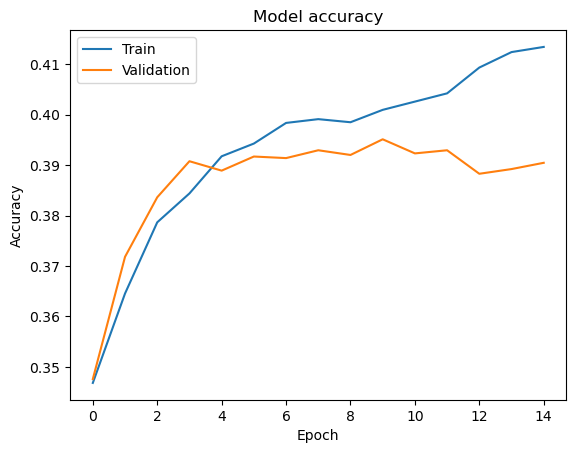

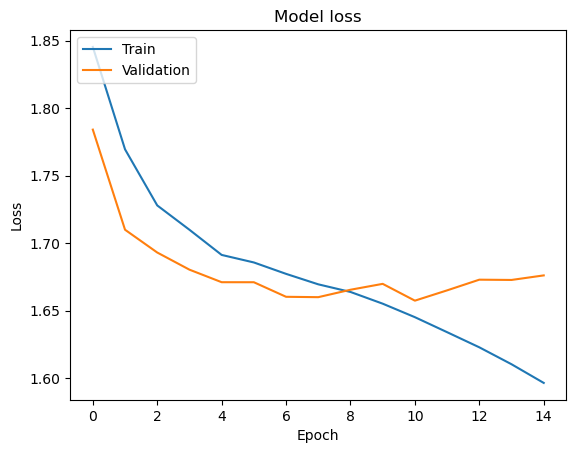

In [351]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [352]:
y_pred = model2.predict([padded_test_data, test_data_static])
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded validation labels to class labels
y_true_classes = np.argmax(test_labels_arr, axis=1)

# Print the classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Print the accuracy
print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))

# Print the macro F1 score
print("Macro F1 Score:", f1_score(y_true_classes, y_pred_classes, average='macro'))

# Print the macro precision
print("Macro Precision:", precision_score(y_true_classes, y_pred_classes, average='macro'))

# Print the macro recall
print("Macro Recall:", recall_score(y_true_classes, y_pred_classes, average='macro'))

# Print the macro and micro AUC-ROC scores
print("Macro AUC-ROC Score:", roc_auc_score(test_labels_arr, y_pred, average='macro', multi_class='ovr'))
print("Micro AUC-ROC Score:", roc_auc_score(test_labels_arr, y_pred, average='micro', multi_class='ovr'))

102/102 [==============================] - 4s 21ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.92      0.62      1194
           1       0.19      0.05      0.07       577
           2       0.00      0.00      0.00       371
           3       0.00      0.00      0.00       228
           4       0.00      0.00      0.00       160
           5       0.00      0.00      0.00       103
           6       0.25      0.33      0.28       343
           7       0.29      0.30      0.30       260

    accuracy                           0.41      3236
   macro avg       0.15      0.20      0.16      3236
weighted avg       0.26      0.41      0.29      3236

Accuracy: 0.40636588380716937
Macro F1 Score: 0.15857609466371925
Macro Precision: 0.14941653011473277
Macro Recall: 0.1996391681970846
Macro AUC-ROC Score: 0.6352404230996112
Micro AUC-ROC Score: 0.7740942004864486


C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metr

In [353]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout

# Define the input shape for the time series data
time_series_input = Input(shape=(None, padded_train_data.shape[2]))

# Define the input shape for the static features
static_input = Input(shape=(train_data_static.shape[1],))

# Create separate LSTM layers for each channel in the time series data
lstm_outputs = []
for i in range(padded_train_data.shape[2]):
    channel_input = time_series_input[:,:,i:i+1]  # Select the i-th channel from the input data
    lstm_layer = LSTM(64, return_sequences=True)(channel_input)
    lstm_layer = LSTM(32)(lstm_layer)
    lstm_outputs.append(lstm_layer)

# Concatenate the outputs of the LSTM layers
concat_lstm = Concatenate()(lstm_outputs)

# Concatenate the LSTM output with the static features
concat_layer = Concatenate()([concat_lstm, static_input])

# Define the dense layers
dense_layer = Dense(64, activation='relu')(concat_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add a Dropout layer with a rate of 0.5
dense_layer = Dense(32, activation='relu')(dense_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add another Dropout layer with a rate of 0.5
# Define the output layer for multi-class classification (use softmax activation)
num_classes = train_labels_onehot.shape[1]  # Get the number of classes from the one-hot encoded labels
output_layer = Dense(num_classes, activation='softmax')(dense_layer)

# Create the model
model3 = Model(inputs=[time_series_input, static_input], outputs=output_layer)

# Compile the model with categorical_crossentropy loss for multi-class classification
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model3.summary()


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, None, 18)]   0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, None, 1)     0           ['input_50[0][0]']               
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, None, 1)     0           ['input_50[0][0]']               
 icingOpLambda)                                                                                   
                                                                                           

In [354]:
history3 = model3.fit(
    [padded_train_data, train_data_static], train_labels_onehot,
    validation_data=([padded_val_data, val_data_static], val_labels_onehot),
    epochs=20,
    batch_size=32
)

Epoch 1/20
459/459 [==============================] - 169s 234ms/step - loss: 1.8348 - accuracy: 0.3457 - val_loss: 1.7621 - val_accuracy: 0.3476
Epoch 2/20
459/459 [==============================] - 97s 211ms/step - loss: 1.7599 - accuracy: 0.3631 - val_loss: 1.7219 - val_accuracy: 0.3696
Epoch 3/20
459/459 [==============================] - 94s 204ms/step - loss: 1.7451 - accuracy: 0.3735 - val_loss: 1.7128 - val_accuracy: 0.3780
Epoch 4/20
459/459 [==============================] - 93s 202ms/step - loss: 1.7267 - accuracy: 0.3761 - val_loss: 1.6741 - val_accuracy: 0.3880
Epoch 5/20
459/459 [==============================] - 93s 202ms/step - loss: 1.7062 - accuracy: 0.3861 - val_loss: 1.6689 - val_accuracy: 0.3914
Epoch 6/20
459/459 [==============================] - 94s 205ms/step - loss: 1.6997 - accuracy: 0.3881 - val_loss: 1.6579 - val_accuracy: 0.3970
Epoch 7/20
459/459 [==============================] - 94s 205ms/step - loss: 1.6868 - accuracy: 0.3944 - val_loss: 1.6772 - val_a

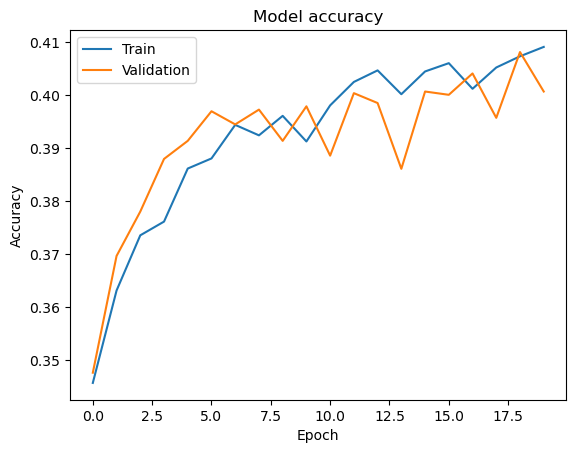

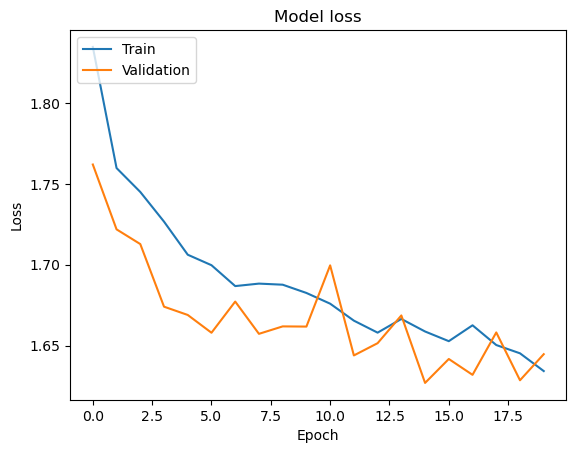

In [355]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [356]:
y_pred = model3.predict([padded_test_data, test_data_static])
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded validation labels to class labels
y_true_classes = np.argmax(test_labels_arr, axis=1)

# Print the classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Print the accuracy
print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))

# Print the macro F1 score
print("Macro F1 Score:", f1_score(y_true_classes, y_pred_classes, average='macro'))

# Print the macro precision
print("Macro Precision:", precision_score(y_true_classes, y_pred_classes, average='macro'))

# Print the macro recall
print("Macro Recall:", recall_score(y_true_classes, y_pred_classes, average='macro'))

# Print the macro and micro AUC-ROC scores
print("Macro AUC-ROC Score:", roc_auc_score(test_labels_arr, y_pred, average='macro', multi_class='ovr'))
print("Micro AUC-ROC Score:", roc_auc_score(test_labels_arr, y_pred, average='micro', multi_class='ovr'))

102/102 [==============================] - 24s 75ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.94      0.64      1194
           1       0.23      0.02      0.04       577
           2       0.00      0.00      0.00       371
           3       0.00      0.00      0.00       228
           4       0.00      0.00      0.00       160
           5       0.00      0.00      0.00       103
           6       0.24      0.39      0.30       343
           7       0.29      0.34      0.31       260

    accuracy                           0.42      3236
   macro avg       0.16      0.21      0.16      3236
weighted avg       0.27      0.42      0.30      3236

Accuracy: 0.4181087762669963
Macro F1 Score: 0.16007245207108334
Macro Precision: 0.15557717791601605
Macro Recall: 0.21077745847087817
Macro AUC-ROC Score: 0.6584234447306241
Micro AUC-ROC Score: 0.7867237074109105


C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metr

In [366]:
input_shape

(61, 18)

In [368]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
# Define model parameters
input_shape = (padded_train_data.shape[1], padded_train_data.shape[2])


# Build the LSTM model
model4 = Sequential()
model4.add(LSTM(64, input_shape=input_shape, return_sequences=True))
model4.add(Dropout(0.3))  # Add dropout layer with 20% dropout rate
model4.add(LSTM(32))
model4.add(Dropout(0.3))  # Add dropout layer with 20% dropout rate
model4.add(Dense(num_classes, activation='softmax'))

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Compile the model with categorical_crossentropy loss for multi-class classification
model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (None, 61, 64)            21248     
                                                                 
 dropout_72 (Dropout)        (None, 61, 64)            0         
                                                                 
 lstm_97 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_73 (Dropout)        (None, 32)                0         
                                                                 
 dense_90 (Dense)            (None, 8)                 264       
                                                                 
Total params: 33,928
Trainable params: 33,928
Non-trainable params: 0
_________________________________________________________________


In [367]:
print("Shape of training data:", padded_train_data.shape)
print("Shape of training labels:", train_labels_onehot.shape)
print("Shape of validation data:", padded_val_data.shape)
print("Shape of validation labels:", val_labels_onehot.shape)


Shape of training data: (14681, 61, 18)
Shape of training labels: (14681, 8)
Shape of validation data: (3222, 61, 18)
Shape of validation labels: (3222, 8)


In [369]:
history4 = model4.fit(
    padded_train_data, train_labels_onehot,
    validation_data=(padded_val_data, val_labels_onehot),
    epochs=20,
    batch_size=32
)

Epoch 1/20
459/459 [==============================] - 30s 54ms/step - loss: 1.8182 - accuracy: 0.3609 - val_loss: 1.7753 - val_accuracy: 0.3631
Epoch 2/20
459/459 [==============================] - 24s 52ms/step - loss: 1.7646 - accuracy: 0.3737 - val_loss: 1.7274 - val_accuracy: 0.3696
Epoch 3/20
459/459 [==============================] - 21s 45ms/step - loss: 1.7263 - accuracy: 0.3793 - val_loss: 1.6914 - val_accuracy: 0.3799
Epoch 4/20
459/459 [==============================] - 20s 44ms/step - loss: 1.7073 - accuracy: 0.3865 - val_loss: 1.6840 - val_accuracy: 0.3852
Epoch 5/20
459/459 [==============================] - 21s 45ms/step - loss: 1.6988 - accuracy: 0.3917 - val_loss: 1.6763 - val_accuracy: 0.3889
Epoch 6/20
459/459 [==============================] - 21s 46ms/step - loss: 1.6880 - accuracy: 0.3959 - val_loss: 1.6728 - val_accuracy: 0.3960
Epoch 7/20
459/459 [==============================] - 21s 46ms/step - loss: 1.6830 - accuracy: 0.3972 - val_loss: 1.6610 - val_accuracy:

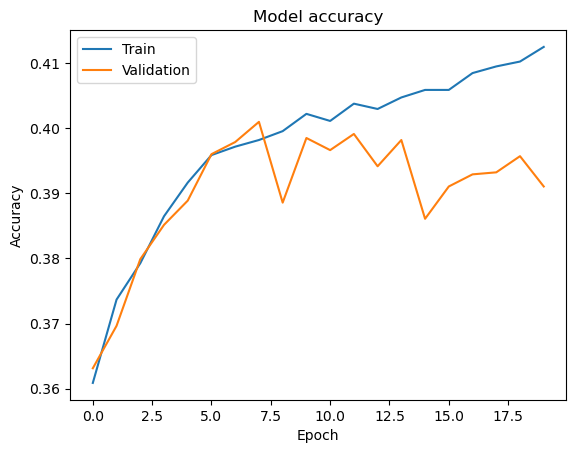

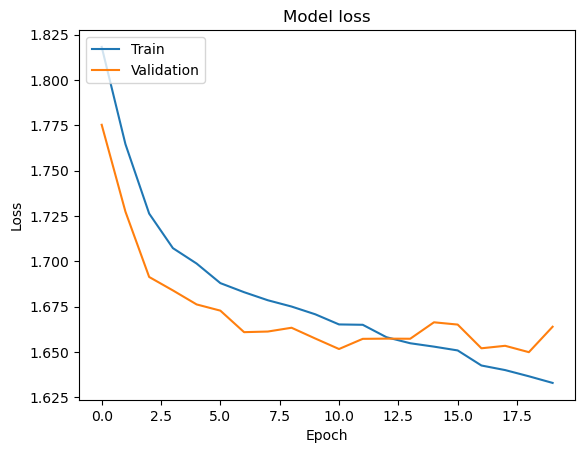

In [370]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [371]:
y_pred = model4.predict(padded_test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded validation labels to class labels
y_true_classes = np.argmax(test_labels_arr, axis=1)

# Print the classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Print the accuracy
print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))

# Print the macro F1 score
print("Macro F1 Score:", f1_score(y_true_classes, y_pred_classes, average='macro'))

# Print the macro precision
print("Macro Precision:", precision_score(y_true_classes, y_pred_classes, average='macro'))

# Print the macro recall
print("Macro Recall:", recall_score(y_true_classes, y_pred_classes, average='macro'))

# Print the macro and micro AUC-ROC scores
print("Macro AUC-ROC Score:", roc_auc_score(test_labels_arr, y_pred, average='macro', multi_class='ovr'))
print("Micro AUC-ROC Score:", roc_auc_score(test_labels_arr, y_pred, average='micro', multi_class='ovr'))

102/102 [==============================] - 4s 19ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.93      0.63      1194
           1       0.12      0.01      0.02       577
           2       0.00      0.00      0.00       371
           3       0.00      0.00      0.00       228
           4       0.00      0.00      0.00       160
           5       0.00      0.00      0.00       103
           6       0.24      0.42      0.31       343
           7       0.26      0.22      0.24       260

    accuracy                           0.41      3236
   macro avg       0.14      0.20      0.15      3236
weighted avg       0.24      0.41      0.29      3236

Accuracy: 0.4088380716934487
Macro F1 Score: 0.14954838112227992
Macro Precision: 0.13756042971526616
Macro Recall: 0.19850400458657186
Macro AUC-ROC Score: 0.6427937818719924
Micro AUC-ROC Score: 0.7782539305408189


C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metr

102/102 [==============================] - 2s 17ms/step


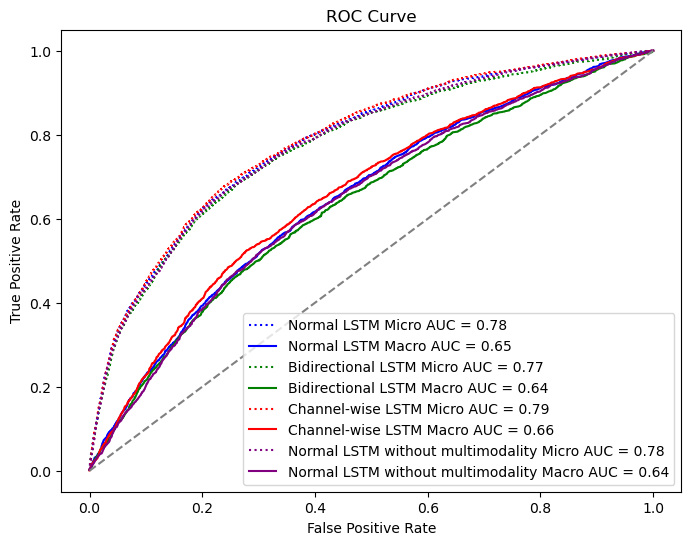

In [379]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(models, X_vals, y_val, labels, colors):
    n_classes = y_val.shape[1]
    
    plt.figure(figsize=(8, 6))

    for i, model in enumerate(models):
        y_score = model.predict(X_vals[i])
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(n_classes):
            fpr[j], tpr[j], _ = roc_curve(y_val[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute macro-average ROC curve and ROC area
        all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for j in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        plt.plot(fpr["micro"], tpr["micro"], color=colors[i], linestyle=':', label='{} Micro AUC = {:.2f}'.format(labels[i], roc_auc["micro"]))
        plt.plot(fpr["macro"], tpr["macro"], color=colors[i], label='{} Macro AUC = {:.2f}'.format(labels[i], roc_auc["macro"]))
        
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

models = [model1, model2, model3, model4]
X_vals = [[padded_test_data, test_data_static], [padded_test_data, test_data_static], [padded_test_data, test_data_static], padded_test_data]
labels = ['Normal LSTM', 'Bidirectional LSTM', 'Channel-wise LSTM', 'Normal LSTM without multimodality']
colors = ['blue', 'green', 'red', 'purple']

plot_roc_curve(models, X_vals, test_labels_arr, labels, colors)


102/102 [==============================] - 2s 16ms/step


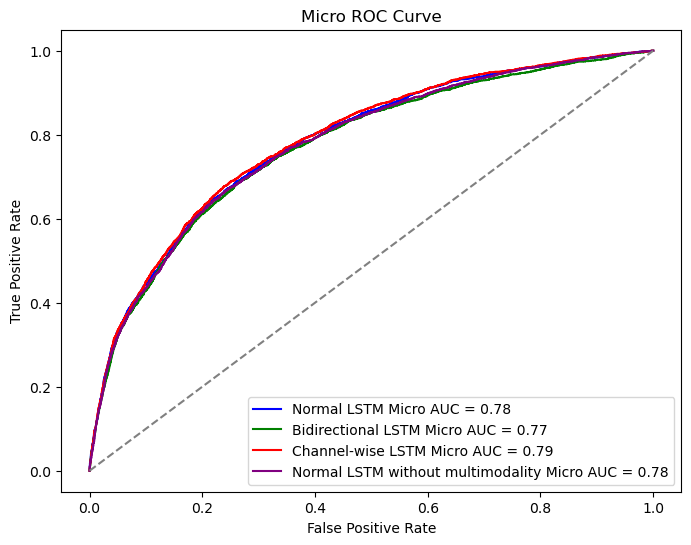

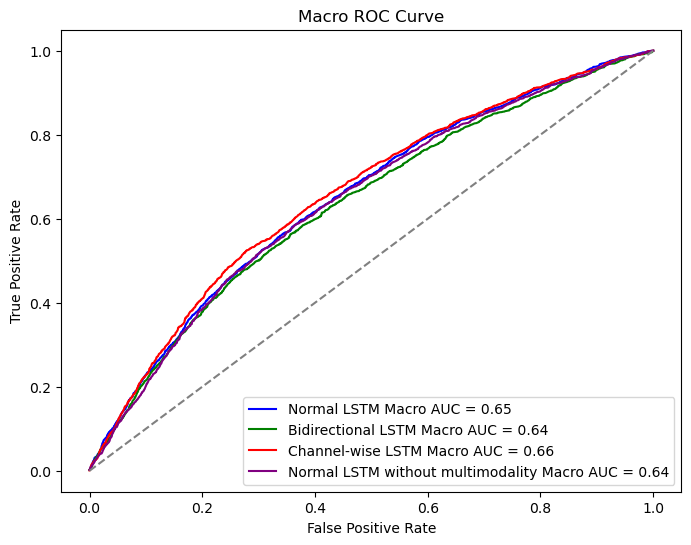

In [380]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(models, X_vals, y_val, labels, colors):
    n_classes = y_val.shape[1]

    def plot_individual_curve(fpr, tpr, roc_auc, curve_type):
        plt.figure(figsize=(8, 6))
        for i, model in enumerate(models):
            plt.plot(fpr[i], tpr[i], color=colors[i], label='{} {} AUC = {:.2f}'.format(labels[i], curve_type, roc_auc[i]))
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('{} ROC Curve'.format(curve_type))
        plt.legend()
        plt.show()

    fpr_micro = []
    tpr_micro = []
    roc_auc_micro = []

    fpr_macro = []
    tpr_macro = []
    roc_auc_macro = []

    for i, model in enumerate(models):
        y_score = model.predict(X_vals[i])

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(n_classes):
            fpr[j], tpr[j], _ = roc_curve(y_val[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
        fpr_micro.append(fpr["micro"])
        tpr_micro.append(tpr["micro"])
        roc_auc_micro.append(auc(fpr["micro"], tpr["micro"]))

        # Compute macro-average ROC curve and ROC area
        all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for j in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        fpr_macro.append(fpr["macro"])
        tpr_macro.append(tpr["macro"])
        roc_auc_macro.append(auc(fpr["macro"], tpr["macro"]))

    plot_individual_curve(fpr_micro, tpr_micro, roc_auc_micro, "Micro")
    plot_individual_curve(fpr_macro, tpr_macro, roc_auc_macro, "Macro")

models = [model1, model2, model3, model4]
X_vals = [[padded_test_data, test_data_static], [padded_test_data, test_data_static], [padded_test_data, test_data_static], padded_test_data]
labels = ['Normal LSTM', 'Bidirectional LSTM', 'Channel-wise LSTM', 'Normal LSTM without multimodality']
colors = ['blue', 'green', 'red', 'purple']

plot_roc_curve(models, X_vals, test_labels_arr, labels, colors)


102/102 [==============================] - 2s 18ms/step


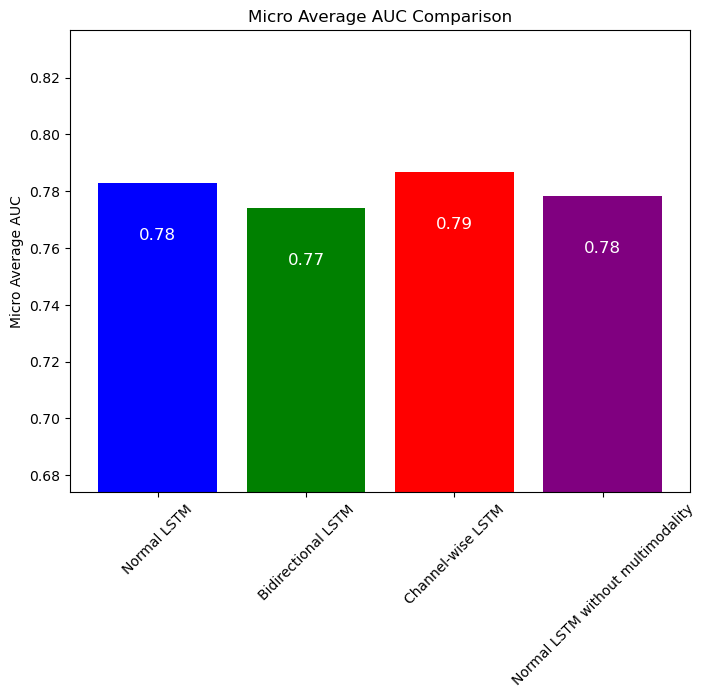

In [382]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_micro_auc_barchart(auc_values, labels, colors):
    plt.figure(figsize=(8, 6))
    for i, auc_value in enumerate(auc_values):
        plt.bar(i, auc_value, color=colors[i], label=labels[i])
        plt.text(i, auc_value - 0.02, f'{auc_value:.2f}', ha='center', color='white', fontsize=12)
    plt.xticks(range(len(auc_values)), labels, rotation=45)
    plt.ylim(min(auc_values) - 0.1, max(auc_values) + 0.05)
    plt.ylabel('Micro Average AUC')
    plt.title('Micro Average AUC Comparison')
    plt.show()

# Generate micro average AUC values for each model
auc_values = []
for i, model in enumerate(models):
    y_score = model.predict(X_vals[i])
    fpr, tpr, _ = roc_curve(test_labels_arr.ravel(), y_score.ravel())
    auc_value = auc(fpr, tpr)
    auc_values.append(auc_value)

plot_micro_auc_barchart(auc_values, labels, colors)


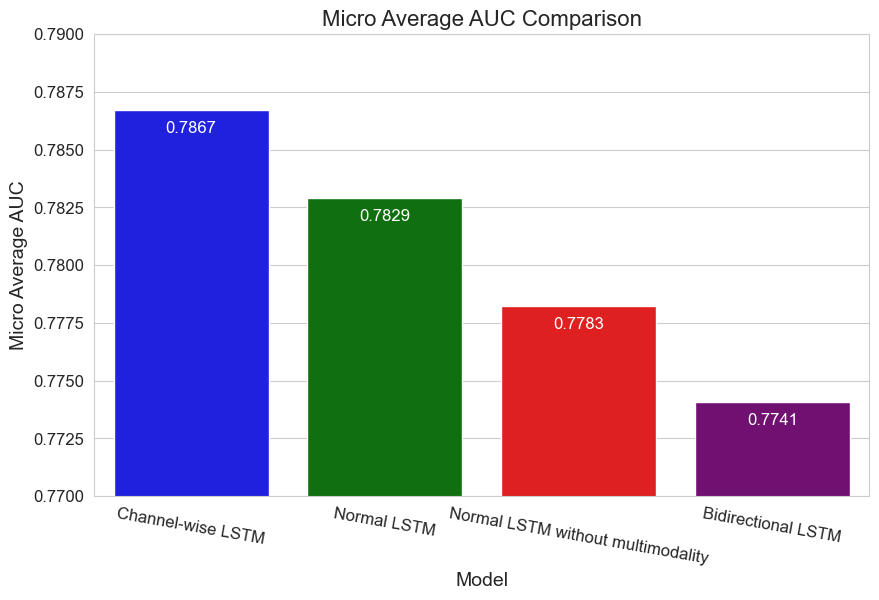

In [390]:
import seaborn as sns
import pandas as pd

# Provided micro average AUC values for each model
auc_values = [0.782905169188585, 0.7740942004864486, 0.7867237074109105, 0.7782539305408189]
labels = ['Normal LSTM', 'Bidirectional LSTM', 'Channel-wise LSTM', 'Normal LSTM without multimodality']
colors = ['blue', 'green', 'red', 'purple']

# Create a DataFrame from the provided data
df = pd.DataFrame({'Model': labels, 'Micro AUC': auc_values})

# Sort the DataFrame by Micro AUC values
df = df.sort_values(by='Micro AUC', ascending=False)

# Set Seaborn style
sns.set_style('whitegrid')

# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Micro AUC', data=df, palette=colors)

# Annotate the bars with the Micro AUC values
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height() - 0.001),
                ha='center', fontsize=12, color='white')

plt.ylim(0.77, 0.79)
plt.ylabel('Micro Average AUC', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.title('Micro Average AUC Comparison', fontsize=16)
plt.xticks(fontsize=12,rotation = -10)
plt.yticks(fontsize=12)
plt.show()


In [2]:
import numpy as np
train_labels = np.load('train_labels_los.npy')

C:\Users\samit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


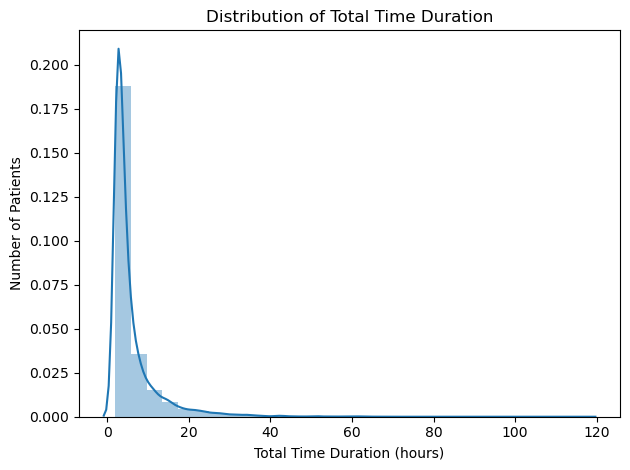

In [11]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.distplot(train_labels, bins=30)
plt.xlabel('Total Time Duration (hours)')
plt.ylabel('Number of Patients')
plt.title('Distribution of Total Time Duration')

plt.tight_layout()
plt.show()